In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                #if np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0:
                if len(dones) > 1:
                    # print('np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0: ', 
                    #       np.count_nonzero(dones), len(dones), np.max(rates))
                    break
            #             if np.count_nonzero(dones)!=1 and len(dones) < 1 and np.max(rates) <= 0:
            #                 print(np.count_nonzero(dones), len(dones), np.max(rates))
            #                 break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            #model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:1.4376 dloss:1.8396 aloss2:1.5736 exploreP:0.9984
Episode:1 meanR:24.5000 R:33.0000 rate:0.0660 aloss:1.4321 dloss:1.8177 aloss2:1.5914 exploreP:0.9952
Episode:2 meanR:20.0000 R:11.0000 rate:0.0220 aloss:1.4204 dloss:1.7933 aloss2:1.6275 exploreP:0.9941
Episode:3 meanR:21.5000 R:26.0000 rate:0.0520 aloss:1.4126 dloss:1.7964 aloss2:1.6044 exploreP:0.9915
Episode:4 meanR:22.0000 R:24.0000 rate:0.0480 aloss:1.4120 dloss:1.7905 aloss2:1.6075 exploreP:0.9892
Episode:5 meanR:20.3333 R:12.0000 rate:0.0240 aloss:1.4046 dloss:1.8075 aloss2:1.5941 exploreP:0.9880
Episode:6 meanR:19.8571 R:17.0000 rate:0.0340 aloss:1.3956 dloss:1.7913 aloss2:1.5957 exploreP:0.9863
Episode:7 meanR:18.8750 R:12.0000 rate:0.0240 aloss:1.4076 dloss:1.7679 aloss2:1.6424 exploreP:0.9852
Episode:8 meanR:18.0000 R:11.0000 rate:0.0220 aloss:1.4024 dloss:1.7083 aloss2:1.7070 exploreP:0.9841
Episode:9 meanR:17.8000 R:16.0000 rate:0.0320 aloss:1.3947 dloss:1.7829 aloss2:1.6

Episode:80 meanR:23.7901 R:19.0000 rate:0.0380 aloss:1.3766 dloss:0.7407 aloss2:4.0159 exploreP:0.8265
Episode:81 meanR:23.8171 R:26.0000 rate:0.0520 aloss:1.3763 dloss:0.7540 aloss2:4.0800 exploreP:0.8244
Episode:82 meanR:23.6988 R:14.0000 rate:0.0280 aloss:1.3766 dloss:0.7223 aloss2:4.4015 exploreP:0.8232
Episode:83 meanR:24.1905 R:65.0000 rate:0.1300 aloss:1.3757 dloss:0.7022 aloss2:4.2919 exploreP:0.8180
Episode:84 meanR:24.7765 R:74.0000 rate:0.1480 aloss:1.3764 dloss:0.7020 aloss2:4.5292 exploreP:0.8120
Episode:85 meanR:25.2558 R:66.0000 rate:0.1320 aloss:1.3756 dloss:0.6874 aloss2:4.6582 exploreP:0.8067
Episode:86 meanR:25.1379 R:15.0000 rate:0.0300 aloss:1.3751 dloss:0.6789 aloss2:4.5963 exploreP:0.8055
Episode:87 meanR:25.0909 R:21.0000 rate:0.0420 aloss:1.3786 dloss:0.6850 aloss2:4.5730 exploreP:0.8039
Episode:88 meanR:25.1124 R:27.0000 rate:0.0540 aloss:1.3765 dloss:0.6665 aloss2:4.5746 exploreP:0.8017
Episode:89 meanR:25.3111 R:43.0000 rate:0.0860 aloss:1.3761 dloss:0.6451 

Episode:159 meanR:37.1800 R:14.0000 rate:0.0280 aloss:1.4055 dloss:0.5503 aloss2:6.2203 exploreP:0.6035
Episode:160 meanR:37.5400 R:58.0000 rate:0.1160 aloss:1.3873 dloss:0.5613 aloss2:6.2673 exploreP:0.6000
Episode:161 meanR:37.7600 R:38.0000 rate:0.0760 aloss:1.4271 dloss:0.5627 aloss2:6.1907 exploreP:0.5978
Episode:162 meanR:37.7900 R:15.0000 rate:0.0300 aloss:1.3694 dloss:0.5497 aloss2:6.0924 exploreP:0.5969
Episode:163 meanR:37.8900 R:25.0000 rate:0.0500 aloss:1.3859 dloss:0.5397 aloss2:6.2003 exploreP:0.5955
Episode:164 meanR:38.6000 R:83.0000 rate:0.1660 aloss:1.3916 dloss:0.5528 aloss2:6.2074 exploreP:0.5906
Episode:165 meanR:38.8900 R:55.0000 rate:0.1100 aloss:1.3963 dloss:0.5919 aloss2:6.1263 exploreP:0.5874
Episode:166 meanR:38.8500 R:15.0000 rate:0.0300 aloss:1.3877 dloss:0.5358 aloss2:6.1591 exploreP:0.5866
Episode:167 meanR:39.0600 R:56.0000 rate:0.1120 aloss:1.3958 dloss:0.5219 aloss2:6.1894 exploreP:0.5834
Episode:168 meanR:39.7600 R:110.0000 rate:0.2200 aloss:1.3970 dl

Episode:238 meanR:95.3700 R:73.0000 rate:0.1460 aloss:1.4116 dloss:0.5615 aloss2:6.0243 exploreP:0.2602
Episode:239 meanR:95.2900 R:67.0000 rate:0.1340 aloss:1.4082 dloss:0.6346 aloss2:6.0504 exploreP:0.2586
Episode:240 meanR:96.3700 R:133.0000 rate:0.2660 aloss:1.4100 dloss:0.6173 aloss2:5.9895 exploreP:0.2553
Episode:241 meanR:97.4100 R:143.0000 rate:0.2860 aloss:1.4092 dloss:0.6012 aloss2:5.9660 exploreP:0.2518
Episode:242 meanR:98.2800 R:132.0000 rate:0.2640 aloss:1.4166 dloss:0.6358 aloss2:5.9950 exploreP:0.2486
Episode:243 meanR:99.2800 R:130.0000 rate:0.2600 aloss:1.4112 dloss:0.5986 aloss2:5.9650 exploreP:0.2455
Episode:244 meanR:100.1900 R:130.0000 rate:0.2600 aloss:1.4014 dloss:0.5965 aloss2:5.9948 exploreP:0.2425
Episode:245 meanR:100.7800 R:74.0000 rate:0.1480 aloss:1.3885 dloss:0.6246 aloss2:5.9794 exploreP:0.2408
Episode:246 meanR:102.5400 R:204.0000 rate:0.4080 aloss:1.4071 dloss:0.6282 aloss2:5.9433 exploreP:0.2361
Episode:247 meanR:104.1200 R:178.0000 rate:0.3560 aloss

Episode:316 meanR:319.3000 R:500.0000 rate:1.0000 aloss:1.3430 dloss:1.1006 aloss2:4.4698 exploreP:0.0233
Episode:317 meanR:323.3300 R:500.0000 rate:1.0000 aloss:1.3373 dloss:1.1201 aloss2:4.3865 exploreP:0.0227
Episode:318 meanR:327.0000 R:500.0000 rate:1.0000 aloss:1.3497 dloss:1.0766 aloss2:4.4540 exploreP:0.0221
Episode:319 meanR:330.5600 R:479.0000 rate:0.9580 aloss:1.3382 dloss:1.1087 aloss2:4.4251 exploreP:0.0215
Episode:320 meanR:334.6600 R:500.0000 rate:1.0000 aloss:1.3452 dloss:1.0825 aloss2:4.4511 exploreP:0.0209
Episode:321 meanR:339.3300 R:500.0000 rate:1.0000 aloss:1.3393 dloss:1.1066 aloss2:4.4716 exploreP:0.0204
Episode:322 meanR:340.5900 R:322.0000 rate:0.6440 aloss:1.3305 dloss:1.1959 aloss2:4.2637 exploreP:0.0201
Episode:323 meanR:344.4200 R:500.0000 rate:1.0000 aloss:1.3302 dloss:1.1626 aloss2:4.2788 exploreP:0.0196
Episode:324 meanR:348.2000 R:500.0000 rate:1.0000 aloss:1.3297 dloss:1.1491 aloss2:4.2304 exploreP:0.0191
Episode:325 meanR:352.3200 R:500.0000 rate:1.0

Episode:394 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2073 dloss:1.5597 aloss2:3.1732 exploreP:0.0104
Episode:395 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2297 dloss:1.5095 aloss2:3.2122 exploreP:0.0104
Episode:396 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2157 dloss:1.5563 aloss2:3.1949 exploreP:0.0104
Episode:397 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2267 dloss:1.5278 aloss2:3.1964 exploreP:0.0103
Episode:398 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2008 dloss:1.5693 aloss2:3.1327 exploreP:0.0103
Episode:399 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2121 dloss:1.5539 aloss2:3.1562 exploreP:0.0103
Episode:400 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.1960 dloss:1.5902 aloss2:3.0728 exploreP:0.0103
Episode:401 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.2138 dloss:1.5613 aloss2:3.1170 exploreP:0.0103
Episode:402 meanR:457.8700 R:500.0000 rate:1.0000 aloss:1.1962 dloss:1.5955 aloss2:3.0827 exploreP:0.0103
Episode:403 meanR:457.8700 R:500.0000 rate:1.0

Episode:472 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.1052 dloss:1.8064 aloss2:2.3312 exploreP:0.0100
Episode:473 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.0973 dloss:1.7996 aloss2:2.3306 exploreP:0.0100
Episode:474 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.0941 dloss:1.7944 aloss2:2.3260 exploreP:0.0100
Episode:475 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.1015 dloss:1.7914 aloss2:2.3333 exploreP:0.0100
Episode:476 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.0998 dloss:1.7897 aloss2:2.3248 exploreP:0.0100
Episode:477 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.1001 dloss:1.7929 aloss2:2.3214 exploreP:0.0100
Episode:478 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.0979 dloss:1.7928 aloss2:2.3200 exploreP:0.0100
Episode:479 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.1014 dloss:1.7955 aloss2:2.3153 exploreP:0.0100
Episode:480 meanR:498.3100 R:500.0000 rate:1.0000 aloss:1.0979 dloss:1.7898 aloss2:2.3199 exploreP:0.0100
Episode:481 meanR:499.2500 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

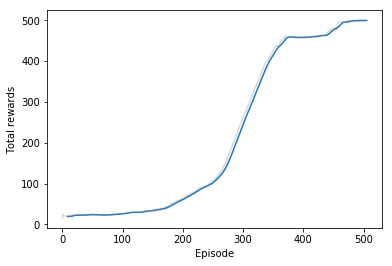

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

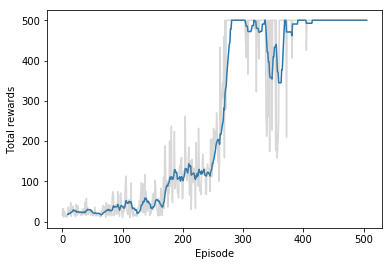

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

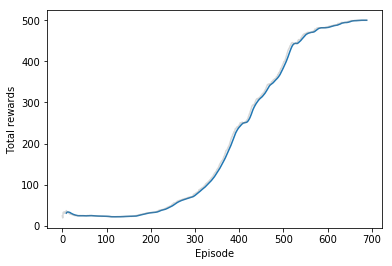

In [51]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

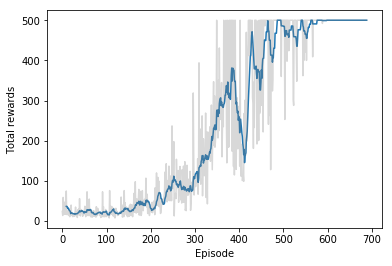

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [53]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [54]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
